In [9]:
import pylab
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import biosig
import time
import pickle
import bz2
import sys

In [2]:
start = time.time()
t1 = start
HDR = biosig.sopen('/home/sweet/1-workdir/eeg001-2017/S01_ME/motorexecution_subject1_run1.gdf','r')
print("Read header in %f s\n" % (time.time()-t1))

t1 = time.time()
data = biosig.sread(HDR, HDR.NRec, 0)
print("Read data in %f s\n" % (time.time()-t1))

biosig.sclose(HDR)


Finished reading header
Read header in 0.003428 s

Finished reading data
Read data in 36.074666 s



0

In [3]:
# map event type to event label
# class 1: 0x600 = 1536 (elbow flexion)
# class 2: 0x601 = 1537 (elbow extension)
# class 3: 0x602 = 1538 (supination)
# class 4: 0x603 = 1539 (pronation)
# class 5: 0x604 = 1540 (hand close)
# class 6: 0x605 = 1541 (hand open)
# class 7: 0x606 = 1542 (rest)

# also, there are event types that signify start of trials, computer beep, cross on screen
# 0x300 = 768 (start of trial)
# 0x311 = 785 (beep)
# 0x312 = 786 (cross on screen)
# numbers that are OR-ed with 0x8000 signify end of event.
event_map = {
    1536: 1,
    1537: 2,
    1538: 3,
    1539: 4,
    1540: 5,
    1541: 6,
    1542: 7
}

seqs_v_class_map = {
    1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []
}

In [4]:
t1 = time.time()
event_hit = 0
start_frame = 0
end_frame = 0
for i in range(len(HDR.EVENT.TYP)):
    code = HDR.EVENT.TYP[i]
    if event_hit == 0 and code in event_map:
        event_hit = code
        start_frame = HDR.EVENT.POS[i]
    
    if code == event_hit + 32768:
        end_frame = HDR.EVENT.POS[i]
        seqs_v_class_map[event_map[event_hit]].append(data[start_frame:end_frame+1, 0:64])
        event_hit = 0
        
print("Finished segregating data into classes in %f s\n" % (time.time()-t1))


Finished segregating data into classes in 0.001870 s



In [5]:
# compress segregated data into zip file
t1 = time.time()
i_str = pickle.dumps(seqs_v_class_map)
compressed_data = bz2.compress(i_str)
f_size = sys.getsizeof(compressed_data)
with bz2.open("compressed_data.bz2", "wb") as f:
    f.write(compressed_data)
    
print("Finished writing %f of data to file in %f s\n" % (f_size, time.time()-t1))

finish = time.time()
print("Done processing file in %f s\n" % (finish - start))

Finished writing 12099142.000000 of data to file in 3.790758 s

Done processing file in 39.892980 s



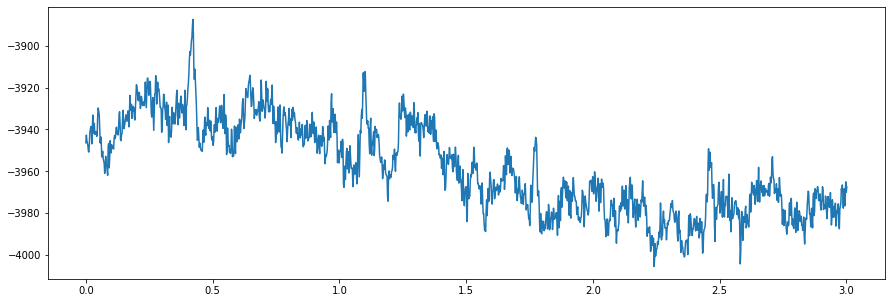

In [31]:
#biosig.destructHDR(HDR)

sig = seqs_v_class_map[7][3][:,0]
t = np.linspace(0, len(sig)/512, len(sig))

plt.figure(figsize = (15,5))
plt.plot(t, sig)

In [40]:
# sos = signal.butter(30, 255, 'lowpass', fs=512, output='sos')
# filtered = signal.sosfilt(sos, sig)

resampled = signal.decimate(seqs_v_class_map[7][3], 2, 30, axis=0)

# plt.figure(figsize = (15,5))
# plt.plot(resampled)

In [41]:
resampled.shape

(769, 64)

In [8]:
# HDR.EVENT.TYP